# Capstone 2, Notebook 3
### Final Model Creation

This notebook will cover the building of a machine learning pipeline to cover how the final product was tested and trained. 

In the prior segments the data was compiled and examined to verify the shape and importance of the features on daily fantasy points. In the second segment, we created many moving averages to test out the theory that stock forecasting techniques could be effectively applied the forecasting of a players' performance. While that did have some validity, it was not significant enough to be the only method.

This segment is to document the creation of a number of new models from the compiled data. The pipeline utilized three models: Stochastic Gradient Descent, random forests, and xgboost. 

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn import preprocessing
from sklearn import utils
import xgboost 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pactools import simulate_pac
from pactools.grid_search import ExtractDriver, AddDriverDelay
from pactools.grid_search import DARSklearn, MultipleArray
from pactools.grid_search import GridSearchCVProgressBar

In [2]:
base_data = pd.read_csv("cleanedPlayerStats.csv.gz", compression='gzip')
print(base_data.shape)

(441586, 490)


In [4]:
pd.set_option('display.max_columns', 800)
base_data.head()

,player,game_order,game_id,index,game_date,season_comp,Team_comp,Opponent_comp,is_home_comp,TOI_comp,G_comp,A1_comp,A2_comp,Points_comp,iSF_comp,iFF_comp,iCF_comp,ixG_comp,iBLK_comp,iHF,iHA,GIVE,TAKE,iPENT2_comp,iPEND2_comp,iPENT5_comp,iPEND5_comp,FOW_comp,FOL_comp,OZS_comp,NZS_comp,DZS_comp,t_TOI_comp,TOI_ev,G_ev,A1_ev,A2_ev,Points_ev,iSF_ev,iFF_ev,iCF_ev,ixG_ev,iBLK_ev,GIVE_o,GIVE_n,GIVE_d,TAKE_o,TAKE_n,TAKE_d,iHF_o,iHF_n,iHF_d,iHA_o,iHA_n,iHA_d,FOW_ev,FOL_ev,OZS_ev,NZS_ev,DZS_ev,iPENT2_ev,iPEND2_ev,iPENT5_ev,iPEND5_ev,onGF,onGA,onSF,onSA,onFF,onFA,onCF,onCA,onxGF,onxGA,onGF_state,onGA_state,onSF_state,onSA_state,onFF_state,onFA_state,onCF_state,onCA_state,onxGF_state,onxGA_state,t_TOI_ev,t_GF,t_GA,t_SF,t_SA,t_FF,t_FA,t_CF,t_CA,t_xGF,t_xGA,t_GF_state,t_GA_state,t_SF_state,t_SA_state,t_FF_state,t_FA_state,t_CF_state,t_CA_state,t_xGF_state,t_xGA_state,TOI,G,A1,A2,Points,iSF,iFF,iCF,ixG,GIVE_o_pp,GIVE_n_pp,GIVE_d_pp,TAKE_o_pp,TAKE_n_pp,TAKE_d_pp,iHF_o_pp,iHF_n_pp,iHF_d_pp,iHA_o_pp,iHA_n_pp,iHA_d_pp,FOW,FOL,OZS,NZS,DZS,iPENT2,iPEND2,iPENT5,iPEND5,onGF_pp,onGA_pp,onSF_pp,onSA_pp,onFF_pp,onFA_pp,onCF_pp,onCA_pp,onxGF_pp,onxGA_pp,onGF_state_pp,onGA_state_pp,onSF_state_pp,onSA_state_pp,onFF_state_pp,onFA_state_pp,onCF_state_pp,onCA_state_pp,onxGF_state_pp,onxGA_state_pp,t_TOI,t_GF_pp,t_GA_pp,t_SF_pp,t_SA_pp,t_FF_pp,t_FA_pp,t_CF_pp,t_CA_pp,t_xGF_pp,t_xGA_pp,t_GF_state_pp,t_GA_state_pp,t_SF_state_pp,t_SA_state_pp,t_FF_state_pp,t_FA_state_pp,t_CF_state_pp,t_CA_state_pp,t_xGF_state_pp,t_xGA_state_pp,TOI_sh,G_sh,A1_sh,A2_sh,Points_sh,iSF_sh,iFF_sh,iCF_sh,ixG_sh,iBLK,GIVE_o_sh,GIVE_n_sh,GIVE_d_sh,TAKE_o_sh,TAKE_n_sh,TAKE_d_sh,iHF_o_sh,iHF_n_sh,iHF_d_sh,iHA_o_sh,iHA_n_sh,iHA_d_sh,FOW_sh,FOL_sh,OZS_sh,NZS_sh,DZS_sh,iPENT2_sh,iPEND2_sh,iPENT5_sh,iPEND5_sh,onGF_sh,onGA_sh,onSF_sh,onSA_sh,onFF_sh,onFA_sh,onCF_sh,onCA_sh,onxGF_sh,onxGA_sh,onGF_state_sh,onGA_state_sh,onSF_state_sh,onSA_state_sh,onFF_state_sh,onFA_state_sh,onCF_state_sh,onCA_state_sh,onxGF_state_sh,onxGA_state_sh,t_TOI_sh,t_GF_sh,t_GA_sh,t_SF_sh,t_SA_sh,t_FF_sh,t_FA_sh,t_CF_sh,t_CA_sh,t_xGF_sh,t_xGA_sh,t_GF_state_sh,t_GA_state_sh,t_SF_state_sh,t_SA_state_sh,t_FF_state_sh,t_FA_state_sh,t_CF_state_sh,t_CA_state_sh,t_xGF_state_sh,t_xGA_state_sh,hat_trick,dk_points,skater_toi_percentage,skater_pptoi_percentage,skater_shtoi_percentage,points_per_60,iFF_per_60,ixG_per_60,position,position_type,firstname,lastname,game_id_avg_lt,TOI_comp_avg_lt,G_comp_avg_lt,Points_comp_avg_lt,iSF_comp_avg_lt,iFF_comp_avg_lt,iCF_comp_avg_lt,ixG_comp_avg_lt,iBLK_comp_avg_lt,iHF_avg_lt,OZS_comp_avg_lt,TOI_ev_avg_lt,G_ev_avg_lt,Points_ev_avg_lt,iSF_ev_avg_lt,iFF_ev_avg_lt,iCF_ev_avg_lt,ixG_ev_avg_lt,iBLK_ev_avg_lt,onGF_avg_lt,onFF_avg_lt,onCF_avg_lt,onxGF_avg_lt,onFA_state_avg_lt,TOI_avg_lt,G_avg_lt,Points_avg_lt,iSF_avg_lt,iFF_avg_lt,iCF_avg_lt,ixG_avg_lt,onGF_pp_avg_lt,onSF_pp_avg_lt,onFF_pp_avg_lt,onCF_pp_avg_lt,onxGF_pp_avg_lt,TOI_sh_avg_lt,G_sh_avg_lt,Points_sh_avg_lt,iSF_sh_avg_lt,iFF_sh_avg_lt,iCF_sh_avg_lt,ixG_sh_avg_lt,onGF_sh_avg_lt,onSF_sh_avg_lt,onFF_sh_avg_lt,onCF_sh_avg_lt,onxGF_sh_avg_lt,onxGA_sh_avg_lt,hat_trick_avg_lt,dk_points_avg_lt,skater_toi_percentage_avg_lt,skater_pptoi_percentage_avg_lt,skater_shtoi_percentage_avg_lt,points_per_60_avg_lt,iFF_per_60_avg_lt,ixG_per_60_avg_lt,game_id_avg_lf,TOI_comp_avg_lf,G_comp_avg_lf,Points_comp_avg_lf,iSF_comp_avg_lf,iFF_comp_avg_lf,iCF_comp_avg_lf,ixG_comp_avg_lf,iBLK_comp_avg_lf,iHF_avg_lf,OZS_comp_avg_lf,TOI_ev_avg_lf,G_ev_avg_lf,Points_ev_avg_lf,iSF_ev_avg_lf,iFF_ev_avg_lf,iCF_ev_avg_lf,ixG_ev_avg_lf,iBLK_ev_avg_lf,onGF_avg_lf,onFF_avg_lf,onCF_avg_lf,onxGF_avg_lf,onFA_state_avg_lf,TOI_avg_lf,G_avg_lf,Points_avg_lf,iSF_avg_lf,iFF_avg_lf,iCF_avg_lf,ixG_avg_lf,onGF_pp_avg_lf,onSF_pp_avg_lf,onFF_pp_avg_lf,onCF_pp_avg_lf,onxGF_pp_avg_lf,TOI_sh_avg_lf,G_sh_avg_lf,Points_sh_avg_lf,iSF_sh_avg_lf,iFF_sh_avg_lf,iCF_sh_avg_lf,ixG_sh_avg_lf,onGF_sh_avg_lf,onSF_sh_avg_lf,onFF_sh_avg_lf,onCF_sh_avg_lf,onxGF_sh_avg_lf,onxGA_sh_avg_lf,hat_trick_avg_lf,dk_points

Here we set the index, and then drop most of the first range of values as they are in that game and shouldn't be used in the forecast models. Players below the 20 game threashold are dropped, as are anyone with na values. These are amost universally over lapping 

In [5]:
base_data.set_index(["player",'game_id',"game_order", "firstname", "lastname"], inplace=True) 

## drop na
base_data.dropna(inplace=True)

## remove game_id random values that got left in
base_data = base_data.drop(base_data.filter(regex='game').columns, axis=1)

## separating out the target variable so it's not accidentially dropped later
target_value = base_data['dk_points'].values  

## one-hot encoding position type as that's a pretty significant variable. 

dfDummies = pd.get_dummies(base_data['position'], prefix = 'position_avg')
playerbg = pd.concat([base_data, dfDummies], axis=1)

playerbg.head()

,,,,,index,season_comp,Team_comp,Opponent_comp,is_home_comp,TOI_comp,G_comp,A1_comp,A2_comp,Points_comp,iSF_comp,iFF_comp,iCF_comp,ixG_comp,iBLK_comp,iHF,iHA,GIVE,TAKE,iPENT2_comp,iPEND2_comp,iPENT5_comp,iPEND5_comp,FOW_comp,FOL_comp,OZS_comp,NZS_comp,DZS_comp,t_TOI_comp,TOI_ev,G_ev,A1_ev,A2_ev,Points_ev,iSF_ev,iFF_ev,iCF_ev,ixG_ev,iBLK_ev,GIVE_o,GIVE_n,GIVE_d,TAKE_o,TAKE_n,TAKE_d,iHF_o,iHF_n,iHF_d,iHA_o,iHA_n,iHA_d,FOW_ev,FOL_ev,OZS_ev,NZS_ev,DZS_ev,iPENT2_ev,iPEND2_ev,iPENT5_ev,iPEND5_ev,onGF,onGA,onSF,onSA,onFF,onFA,onCF,onCA,onxGF,onxGA,onGF_state,onGA_state,onSF_state,onSA_state,onFF_state,onFA_state,onCF_state,onCA_state,onxGF_state,onxGA_state,t_TOI_ev,t_GF,t_GA,t_SF,t_SA,t_FF,t_FA,t_CF,t_CA,t_xGF,t_xGA,t_GF_state,t_GA_state,t_SF_state,t_SA_state,t_FF_state,t_FA_state,t_CF_state,t_CA_state,t_xGF_state,t_xGA_state,TOI,G,A1,A2,Points,iSF,iFF,iCF,ixG,GIVE_o_pp,GIVE_n_pp,GIVE_d_pp,TAKE_o_pp,TAKE_n_pp,TAKE_d_pp,iHF_o_pp,iHF_n_pp,iHF_d_pp,iHA_o_pp,iHA_n_pp,iHA_d_pp,FOW,FOL,OZS,NZS,DZS,iPENT2,iPEND2,iPENT5,iPEND5,onGF_pp,onGA_pp,onSF_pp,onSA_pp,onFF_pp,onFA_pp,onCF_pp,onCA_pp,onxGF_pp,onxGA_pp,onGF_state_pp,onGA_state_pp,onSF_state_pp,onSA_state_pp,onFF_state_pp,onFA_state_pp,onCF_state_pp,onCA_state_pp,onxGF_state_pp,onxGA_state_pp,t_TOI,t_GF_pp,t_GA_pp,t_SF_pp,t_SA_pp,t_FF_pp,t_FA_pp,t_CF_pp,t_CA_pp,t_xGF_pp,t_xGA_pp,t_GF_state_pp,t_GA_state_pp,t_SF_state_pp,t_SA_state_pp,t_FF_state_pp,t_FA_state_pp,t_CF_state_pp,t_CA_state_pp,t_xGF_state_pp,t_xGA_state_pp,TOI_sh,G_sh,A1_sh,A2_sh,Points_sh,iSF_sh,iFF_sh,iCF_sh,ixG_sh,iBLK,GIVE_o_sh,GIVE_n_sh,GIVE_d_sh,TAKE_o_sh,TAKE_n_sh,TAKE_d_sh,iHF_o_sh,iHF_n_sh,iHF_d_sh,iHA_o_sh,iHA_n_sh,iHA_d_sh,FOW_sh,FOL_sh,OZS_sh,NZS_sh,DZS_sh,iPENT2_sh,iPEND2_sh,iPENT5_sh,iPEND5_sh,onGF_sh,onGA_sh,onSF_sh,onSA_sh,onFF_sh,onFA_sh,onCF_sh,onCA_sh,onxGF_sh,onxGA_sh,onGF_state_sh,onGA_state_sh,onSF_state_sh,onSA_state_sh,onFF_state_sh,onFA_state_sh,onCF_state_sh,onCA_state_sh,onxGF_state_sh,onxGA_state_sh,t_TOI_sh,t_GF_sh,t_GA_sh,t_SF_sh,t_SA_sh,t_FF_sh,t_FA_sh,t_CF_sh,t_CA_sh,t_xGF_sh,t_xGA_sh,t_GF_state_sh,t_GA_state_sh,t_SF_state_sh,t_SA_state_sh,t_FF_state_sh,t_FA_state_sh,t_CF_state_sh,t_CA_state_sh,t_xGF_state_sh,t_xGA_state_sh,hat_trick,dk_points,skater_toi_percentage,skater_pptoi_percentage,skater_shtoi_percentage,points_per_60,iFF_per_60,ixG_per_60,position,position_type,TOI_comp_avg_lt,G_comp_avg_lt,Points_comp_avg_lt,iSF_comp_avg_lt,iFF_comp_avg_lt,iCF_comp_avg_lt,ixG_comp_avg_lt,iBLK_comp_avg_lt,iHF_avg_lt,OZS_comp_avg_lt,TOI_ev_avg_lt,G_ev_avg_lt,Points_ev_avg_lt,iSF_ev_avg_lt,iFF_ev_avg_lt,iCF_ev_avg_lt,ixG_ev_avg_lt,iBLK_ev_avg_lt,onGF_avg_lt,onFF_avg_lt,onCF_avg_lt,onxGF_avg_lt,onFA_state_avg_lt,TOI_avg_lt,G_avg_lt,Points_avg_lt,iSF_avg_lt,iFF_avg_lt,iCF_avg_lt,ixG_avg_lt,onGF_pp_avg_lt,onSF_pp_avg_lt,onFF_pp_avg_lt,onCF_pp_avg_lt,onxGF_pp_avg_lt,TOI_sh_avg_lt,G_sh_avg_lt,Points_sh_avg_lt,iSF_sh_avg_lt,iFF_sh_avg_lt,iCF_sh_avg_lt,ixG_sh_avg_lt,onGF_sh_avg_lt,onSF_sh_avg_lt,onFF_sh_avg_lt,onCF_sh_avg_lt,onxGF_sh_avg_lt,onxGA_sh_avg_lt,hat_trick_avg_lt,dk_points_avg_lt,skater_toi_percentage_avg_lt,skater_pptoi_percentage_avg_lt,skater_shtoi_percentage_avg_lt,points_per_60_avg_lt,iFF_per_60_avg_lt,ixG_per_60_avg_lt,TOI_comp_avg_lf,G_comp_avg_lf,Points_comp_avg_lf,iSF_comp_avg_lf,iFF_comp_avg_lf,iCF_comp_avg_lf,ixG_comp_avg_lf,iBLK_comp_avg_lf,iHF_avg_lf,OZS_comp_avg_lf,TOI_ev_avg_lf,G_ev_avg_lf,Points_ev_avg_lf,iSF_ev_avg_lf,iFF_ev_avg_lf,iCF_ev_avg_lf,ixG_ev_avg_lf,iBLK_ev_avg_lf,onGF_avg_lf,onFF_avg_lf,onCF_avg_lf,onxGF_avg_lf,onFA_state_avg_lf,TOI_avg_lf,G_avg_lf,Points_avg_lf,iSF_avg_lf,iFF_avg_lf,iCF_avg_lf,ixG_avg_lf,onGF_pp_avg_lf,onSF_pp_avg_lf,onFF_pp_avg_lf,onCF_pp_avg_lf,onxGF_pp_avg_lf,TOI_sh_avg_lf,G_sh_avg_lf,Points_sh_avg_lf,iSF_sh_avg_lf,iFF_sh_avg_lf,iCF_sh_avg_lf,ixG_sh_avg_lf,onGF_sh_avg_lf,onSF_sh_avg_lf,onFF_sh_avg_lf,onCF_sh_avg_lf,onxGF_sh_avg_lf,onxGA_sh_avg_lf,hat_trick_avg_lf,dk_points_avg_lf,skater_toi_percentage_avg_lf,skater_pptoi_percentage_avg_lf,skater_shtoi_

In [6]:
## find and drop any value that doesn't have _avg in the title (aka any past value, none of the current ones)
new_cols = [col for col in playerbg.columns if '_avg' in col]

playerbg = playerbg[new_cols].values  


In [7]:
## split the data
X_train, X_test, y_train, y_test = train_test_split(playerbg, target_value, test_size=0.2, random_state=123)

print( X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(299586, 228) (299586,)
(74897, 228) (74897,)


In [8]:
# Construct some pipelines
pipe_sgd = Pipeline([('scl', StandardScaler()), ('clf', SGDRegressor())])

pipe_rf = Pipeline([('scl', StandardScaler()),('clf', RandomForestRegressor(random_state=123))])

pipe_xgb = Pipeline([('scl', StandardScaler()),('clf', xgboost.XGBRegressor(random_state=123))])

In [9]:
# Set grid search params
#param_range = [1, 2, 3, 4, 5, 6, 7, 8]
md_range = [1,2,5,10]
param_range_fl = [1.0, 0.5, 0.1]
param_range_treesd = [ None,3,  5]
param_range_treesf = [None, 10, 25]
param_range_treeml = [50, 100, 200] 
param_range_treesne = [500, 600, 700] 
e_stop = [10]
tol = [0.01]


grid_params_sgd = [{'clf__max_iter':param_range_treesne,'clf__tol':tol,'clf__n_iter_no_change':e_stop}]

grid_params_rf = [{'clf__min_samples_leaf': param_range_treeml,'clf__max_depth': md_range, 'clf__min_samples_split': param_range_treeml, "clf__min_impurity_decrease":e_stop}]

grid_params_xgb = [{'clf__min_samples_leaf': param_range_treeml,'clf__max_depth': md_range,  'clf__n_samples_split':param_range_treesne, "clf__early_stopping_rounds":e_stop}]

In [10]:
# Construct grid searches
jobs = -1
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

gs_sgd = GridSearchCV(estimator=pipe_sgd,param_grid=grid_params_sgd, scoring='r2',cv=5,n_jobs=jobs, verbose = 10)

gs_rf = GridSearchCV(estimator=pipe_rf,param_grid=grid_params_rf,cv=5,n_jobs=jobs,verbose = 10)


gs_xgb = GridSearchCV(estimator=pipe_xgb,param_grid=grid_params_xgb,scoring='r2',cv=3,n_jobs=jobs,verbose = 10)

In [ ]:
## here we'll start with the sgd
import time
sgd_start = time.gmtime()
gs_sgd.fit(X_train, y_train)
sgd_end = time.gmtime()
print("GridSearchCV for SGD took %.2f seconds for %d candidate parameter settings."% (time.mktime(time.gmtime()) - time.mktime(sgd_start), len(gs_sgd.cv_results_['params'])))
gs_sgd.best_params_

In [ ]:
y_pred = gs_sgd.predict(X_test)
print('R2:', r2_score(y_test, y_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred))) 

In [ ]:
## random forest regressor
import time
start = time.gmtime()
gs_rf.fit(X_train, y_train)
end = time.gmtime()
print("GridSearchCV took %.2f seconds for %d candidate parameter settings." % (time.mktime(time.gmtime()) - time.mktime(start), len(gs_rf.cv_results_['params'])))
gs_rf.best_params_

In [ ]:
gsy_pred = gs_rf.predict(X_test)
print('R2 Error:', r2_score(y_test, gsy_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, gsy_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, gsy_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, gsy_pred))) 

In [79]:
## I reduced the folds here seeing the earlier errors, and wanting to reduce time
import time
xgb_start = time.gmtime()
gs_xgb.fit(X_train, y_train)
xgb_end = time.gmtime()
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."% (time.mktime(time.gmtime()) - time.mktime(xgb_start), len(gs_xgb.cv_results_['params'])))
gs_xgb.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 26.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 35.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 47.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 65.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 93.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 143.7min
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 104 out of 108 | elapsed: 227.2min remainin

[18:41:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
GridSearchCV took 14397.00 seconds for 36 candidate parameter settings.


{'clf__early_stopping_rounds': 10,
 'clf__max_depth': 2,
 'clf__min_samples_leaf': 50,
 'clf__n_samples_split': 500}

In [80]:
gsxgb_pred = gs_xgb.predict(X_test)
print('R2 Error:', r2_score(y_test, gsxgb_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, gsxgb_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, gsxgb_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, gsxgb_pred))) 

R2 Error: 0.14384249947486516
Mean Absolute Error: 1.341684058443692
Mean Squared Error: 3.3243119380352555
Root Mean Squared Error: 1.8232695736054105


Unfortunately, these models have some kind of either overfitting or multicolinearity (where the variables are highly correlated amongst themselves) since the r2 values are quite poor, in most cases showing barely any predictive value, and in one case actually being worse than random chance. Backwards looking analysis on the feature set was performed first using Variance Inflation Factor (VIF) to see if the values had high multicolinearity. 

This was revealing as there were a number of values that were exceptionally high here. The general recommendation is to cut off at a value between 5-10. In that case this would eliminate 208 of 228 values, including many that we've seen as highly valuable in the past: TOI over the last ten games ends up at 601, and TOI over the last 20 is at an astounding 4993. 

Perhaps most problematic is that a rebalance using only this metric would leave us relying heavily on short handed events, that is, how teams play when they are penalized. Cutting at VIF<10 would leave 36 values, 17 of which are related to Short Handed events, cutting at VIF<=5 would leave 15 values, 6 of which are short handed. 

The problem with this is that Short Handed play is a relatively low percentage of the game, and short handed points are extremely isolated, and the scoring in this format does not add additional points for scoring in this manner. In order to try and trim the features in a more sensable way, the VIF was re-run removing both short handed events AND the averages for the last 10 games. Last 10 was isolated because last 20 shows a global number, while last 5 was effective in calculating 

In [11]:
# For each X, calculate VIF and save in dataframe
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(playerbg, i) for i in range(playerbg.shape[1])]
vif["features"] = new_cols

/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [12]:
vif.sort_values('VIF Factor')

,VIF Factor,features
18,2.135616,onGF_avg_lt
41,2.285870,ixG_sh_avg_lt
51,2.292103,skater_pptoi_percentage_avg_lt
42,2.602651,onGF_sh_avg_lt
209,2.813716,ixG_sh_avg_ltwen
...,...,...
202,inf,onxGF_pp_avg_ltwen
93,inf,Points_sh_avg_lf
90,inf,onxGF_pp_avg_lf
88,inf,onFF_pp_avg_lf


In [25]:
vif[vif.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]

vif = vif.replace([np.inf, -np.inf], np.nan)

In [26]:
vif.dropna(inplace=True)

vif.sort_values('VIF Factor', ascending=False, inplace=True)
vif[0:10]

,VIF Factor,features
168,4993.373639,TOI_comp_avg_ltwen
112,4472.980077,TOI_comp_avg_lten
56,2157.067187,TOI_comp_avg_lf
218,1777.599892,skater_toi_percentage_avg_ltwen
162,1578.112393,skater_toi_percentage_avg_lten
172,1337.753655,iFF_comp_avg_ltwen
178,1318.780464,TOI_ev_avg_ltwen
122,1235.849200,TOI_ev_avg_lten
116,1215.060107,iFF_comp_avg_lten
173,791.597835,iCF_comp_avg_ltwen


In [13]:
dfDummies = pd.get_dummies(base_data['position'], prefix = 'position_avg')
playerbg = pd.concat([base_data, dfDummies], axis=1)

just taking another look at correlation and co-linearity:

In [31]:
## fun but messy plotting
corr = base_data.corr(method='pearson')

In [68]:
corr[0:100,0:100]

TypeError: '(slice(0, 100, None), slice(0, 100, None))' is an invalid key

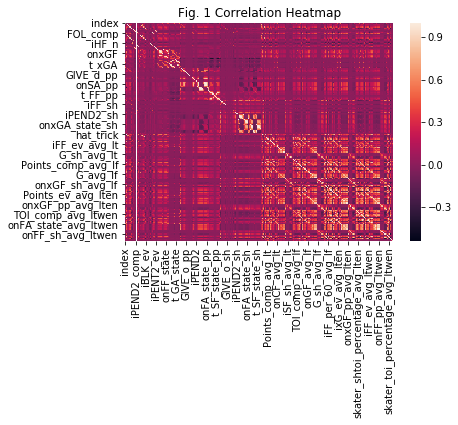

In [77]:
import seaborn as sns

ax = plt.axes()

sns.heatmap(corr, ax = ax)
ax.set_title('Fig. 1 Correlation Heatmap')
plt.savefig('heatmap.png')

In [38]:
points_corr = corr['dk_points']

In [39]:
points_corr.dropna(inplace=True)

In [75]:
print('Fig. 1 Values Most Correlated To Fantasy Points')
print('')
print(points_corr.sort_values(ascending=False)[0:15])

Fig. 1 Values Most Correlated To Fantasy Points

dk_points        1.000000
Points_comp      0.865304
points_per_60    0.803632
G_comp           0.778477
Points_ev        0.708439
iSF_comp         0.644824
G_ev             0.634185
iFF_comp         0.582127
iSF_ev           0.540415
iCF_comp         0.529217
iFF_ev           0.486187
iFF_per_60       0.483516
A1_comp          0.467610
iCF_ev           0.440899
A1_ev            0.375535
Name: dk_points, dtype: float64


In [78]:
filt = ['_avg_ltwen', 'signal', '_avg_lf','position_avg']
kwstr = '|'.join(filt)
playerbg.loc[:, playerbg.columns.str.contains(kwstr)]


,,,,,TOI_comp_avg_lf,G_comp_avg_lf,Points_comp_avg_lf,iSF_comp_avg_lf,iFF_comp_avg_lf,iCF_comp_avg_lf,ixG_comp_avg_lf,iBLK_comp_avg_lf,iHF_avg_lf,OZS_comp_avg_lf,TOI_ev_avg_lf,G_ev_avg_lf,Points_ev_avg_lf,iSF_ev_avg_lf,iFF_ev_avg_lf,iCF_ev_avg_lf,ixG_ev_avg_lf,iBLK_ev_avg_lf,onGF_avg_lf,onFF_avg_lf,onCF_avg_lf,onxGF_avg_lf,onFA_state_avg_lf,TOI_avg_lf,G_avg_lf,Points_avg_lf,iSF_avg_lf,iFF_avg_lf,iCF_avg_lf,ixG_avg_lf,onGF_pp_avg_lf,onSF_pp_avg_lf,onFF_pp_avg_lf,onCF_pp_avg_lf,onxGF_pp_avg_lf,TOI_sh_avg_lf,G_sh_avg_lf,Points_sh_avg_lf,iSF_sh_avg_lf,iFF_sh_avg_lf,iCF_sh_avg_lf,ixG_sh_avg_lf,onGF_sh_avg_lf,onSF_sh_avg_lf,onFF_sh_avg_lf,onCF_sh_avg_lf,onxGF_sh_avg_lf,onxGA_sh_avg_lf,hat_trick_avg_lf,dk_points_avg_lf,skater_toi_percentage_avg_lf,skater_pptoi_percentage_avg_lf,skater_shtoi_percentage_avg_lf,points_per_60_avg_lf,iFF_per_60_avg_lf,ixG_per_60_avg_lf,TOI_comp_avg_ltwen,G_comp_avg_ltwen,Points_comp_avg_ltwen,iSF_comp_avg_ltwen,iFF_comp_avg_ltwen,iCF_comp_avg_ltwen,ixG_comp_avg_ltwen,iBLK_comp_avg_ltwen,iHF_avg_ltwen,OZS_comp_avg_ltwen,TOI_ev_avg_ltwen,G_ev_avg_ltwen,Points_ev_avg_ltwen,iSF_ev_avg_ltwen,iFF_ev_avg_ltwen,iCF_ev_avg_ltwen,ixG_ev_avg_ltwen,iBLK_ev_avg_ltwen,onGF_avg_ltwen,onFF_avg_ltwen,onCF_avg_ltwen,onxGF_avg_ltwen,onFA_state_avg_ltwen,TOI_avg_ltwen,G_avg_ltwen,Points_avg_ltwen,iSF_avg_ltwen,iFF_avg_ltwen,iCF_avg_ltwen,ixG_avg_ltwen,onGF_pp_avg_ltwen,onSF_pp_avg_ltwen,onFF_pp_avg_ltwen,onCF_pp_avg_ltwen,onxGF_pp_avg_ltwen,TOI_sh_avg_ltwen,G_sh_avg_ltwen,Points_sh_avg_ltwen,iSF_sh_avg_ltwen,iFF_sh_avg_ltwen,iCF_sh_avg_ltwen,ixG_sh_avg_ltwen,onGF_sh_avg_ltwen,onSF_sh_avg_ltwen,onFF_sh_avg_ltwen,onCF_sh_avg_ltwen,onxGF_sh_avg_ltwen,onxGA_sh_avg_ltwen,hat_trick_avg_ltwen,dk_points_avg_ltwen,skater_toi_percentage_avg_ltwen,skater_pptoi_percentage_avg_ltwen,skater_shtoi_percentage_avg_ltwen,points_per_60_avg_ltwen,iFF_per_60_avg_ltwen,ixG_per_60_avg_ltwen,toi_signal,FF_signal,position_avg_C,position_avg_D,position_avg_L,position_avg_R
player,game_id,game_order,firstname,lastname,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
JAKE.GARDINER,2017020948,81,JAKE,GARDINER,19.000000,0.0,0.4,1.2,2.0,3.4,0.203709,1.0,1.2,9.8,16.313333,0.0,0.4,1.2,1.6,2.2,0.189953,0.8,0.8,11.8,14.4,1.020746,14.0,2.093333e+00,0.0,0.0,0.0,0.2,0.4,0.008397,0.0,1.2,2.0,2.2,2.0,3.400058e-16,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,7.771561e-17,0.000000e+00,0.0,1.9,0.311094,6.330975e-01,0.000000e+00,1.161099,6.920076,0.613103,22.256667,0.05,0.45,1.65,2.55,3.95,0.280910,1.35,0.75,10.00,19.430833,0.05,0.35,1.35,2.10,3.00,0.264395,1.30,1.05,13.95,18.65,1.431455,15.10,2.103333,0.00,0.05,0.10,0.20,0.40,0.008196,0.10,1.15,1.65,2.15,1.65,0.239167,0.00,0.00,0.05,0.05,0.05,9.301955e-09,0.05,0.15,0.20,0.25,0.011876,8.442556e-03,0.0,2.450,0.366408,0.555010,7.177201e-02,1.260214,7.004662,0.759096,0.0,0.0,0,1,0,0
SCOTT.HARTNELL,2010020556,495,SCOTT,HARTNELL,15.403333,0.2,0.2,2.8,3.6,4.2,0.482322,0.2,2.2,5.4,12.610000,0.0,0.0,2.2,2.8,3.4,0.359873,0.2,0.8,13.2,17.0,0.510989,8.4,2.760000e+00,0.2,0.2,0.6,0.8,0.8,0.122450,0.2,1.4,2.6,3.0,2.6,3.333333e-02,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.2,0.2,0.2,6.972694e-03,0.000000e+00,0.0,2.1,0.256722,5.133432e-01,5.617978e-03,0.720721,13.449233,1.926652,16.679167,0.15,0.40,2.80,3.45,4.10,0.371904,0.25,2.05,7.50,13.415833,0.10,0.30,2.45,2.95,3.50,0.312995,0.25,0.65,11.65,15.30,1.150515,9.55,3.119167,0.05,0.05,0.15,0.20,0.25,0.030612,0.05,1.50,2.35,3.05,2.35,0.049167,0.00,0.00,0.00,0.00,0.00,0.000000e+00,0.00,0.10,0.10,0.10,0.002495,0.000000e+00,0.0,2.475,0.272263,0.447993,6.673253e-03,1.472518,12.572599,1.393385,0.0,0.0,0,0,1,0
ERIC.STAAL,2016020538,221,ERIC,STAAL,19.970000,0.4,1.0,1.6,2.8,3.6,0.323938,0.8,0.6,8.2,14.960000,0.0,0.2,1.0,1.6,2.2,0.033124,0.6,0.4,10.8,16.8,1.422895,11.0,2.813333e+00,0.0,0.4,0.0,0.2,0.4,0.012323,0.4,1.6,2.4,3.2,2.4,1.643333e+00,0.2,0.2,0.2,0.4,0.4,1.643983e-02,0.0,0.0,0.8,1.0,2.042521e-02,1.038109e-01,0.0,3.8,0.

In [15]:
playerbg_sm = playerbg.loc[:, playerbg.columns.str.contains(kwstr)]

In [16]:
vif2 = pd.DataFrame()
vif2["VIF Factor"] = [variance_inflation_factor(playerbg_sm.values, i) for i in range(playerbg_sm.shape[1])]
vif2["features"] = playerbg_sm.columns

In [17]:
vif2.sort_values(by='VIF Factor', ascending=True)

,VIF Factor,features
113,1.534299,FF_signal
112,1.715594,toi_signal
41,1.831807,ixG_sh_avg_lf
97,1.886094,ixG_sh_avg_ltwen
18,1.919839,onGF_avg_lf
...,...,...
59,inf,iSF_comp_avg_ltwen
63,inf,iBLK_comp_avg_ltwen
88,inf,onFF_pp_avg_ltwen
48,inf,hat_trick_avg_lf


Forgot to remove the short handed things so re-running without those.

In [ ]:
## remove game_id random values that got left in
playerbg_sm2 = playerbg_sm.drop(playerbg_sm.filter(regex='_sh').columns, axis=1)
playerbg_sm2.head()

In [ ]:
vif3 = pd.DataFrame()
vif3["VIF Factor"] = [variance_inflation_factor(playerbg_sm2.values, i) for i in range(playerbg_sm2.shape[1])]
vif3["features"] = playerbg_sm2.columns

In [ ]:
vif3.to_csv('vif3.csv')
vif_list = vif3[vif3['VIF Factor']<=10].sort_values(by='VIF Factor')
vif_list

Using these values the model build was repeated with the trimmed feature list.

In [ ]:
newplayerbg = playerbg_sm2[vif_list['features'].tolist()]
newplayerbg

In [ ]:
## split the data
X_train, X_test, y_train, y_test = train_test_split(newplayerbg.values, target_value, test_size=0.2, random_state=123)

print( X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

Since the pipelines were already built those are recycled, which also gave a good point of comparison. The Grids were slightly tweeked as seen in the next cell.

In [ ]:
# Set grid search params
#param_range = [1, 2, 3, 4, 5, 6, 7, 8]
md_range = [1,2,5,10]
param_range_fl = [1.0, 0.5, 0.1]
param_range_treesd = [ None,3,  5]
param_range_treesd = [ 1,3,  5]
param_range_treesf = [None, 10, 20]
param_range_treesne = [500, 600, 700] 
e_stop = [10]
tol = [0.01]


grid_params_sgd = [{'clf__max_iter':param_range_treesne,'clf__tol':tol,'clf__n_iter_no_change':e_stop}]

grid_params_rf = [{"clf__max_features": param_range_treesf,'clf__max_depth': param_range_treesd, 'clf__n_estimators': param_range_treeml, "clf__min_impurity_decrease":e_stop}]

grid_params_xgb = [{"clf__max_features": param_range_treesf,'clf__max_depth': param_range_treesd,  'clf__n_estimators':param_range_treesne, "clf__early_stopping_rounds":e_stop}]

# Construct grid searches
jobs = -1
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

gs_sgd = GridSearchCV(estimator=pipe_sgd,param_grid=grid_params_sgd, scoring='r2',cv=5,n_jobs=jobs, verbose = 10)

gs_rf = GridSearchCV(estimator=pipe_rf,param_grid=grid_params_rf,cv=5,n_jobs=jobs,verbose = 10)


gs_xgb = GridSearchCV(estimator=pipe_xgb,param_grid=grid_params_xgb,scoring='r2',cv=3,n_jobs=jobs,verbose = 10)

In [ ]:
## here we'll start with the sgd
import time
sgd_start = time.gmtime()
gs_sgd.fit(X_train, y_train)
sgd_end = time.gmtime()
print("GridSearchCV for SGD took %.2f seconds for %d candidate parameter settings."% (time.mktime(time.gmtime()) - time.mktime(sgd_start), len(gs_sgd.cv_results_['params'])))
gs_sgd.best_params_

In [ ]:
y_pred = gs_sgd.predict(X_test)
print('R2:', r2_score(y_test, y_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred))) 

Not wanting to totally ignore any critical values, a Principle Componant Analysis was performed on the values in the table and then married to the results of the VIF analysis.

In [ ]:
## random forest regressor
import time
start = time.gmtime()
gs_rf.fit(X_train, y_train)
end = time.gmtime()
print("GridSearchCV took %.2f seconds for %d candidate parameter settings." % (time.mktime(time.gmtime()) - time.mktime(start), len(gs_rf.cv_results_['params'])))
gs_rf.best_params_

In [ ]:
gsy_pred = gs_rf.predict(X_test)
print('R2 Error:', r2_score(y_test, gsy_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, gsy_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, gsy_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, gsy_pred))) 

In [ ]:
## I reduced the folds here seeing the earlier errors, and wanting to reduce time
import time
xgb_start = time.gmtime()
gs_xgb.fit(X_train, y_train)
xgb_end = time.gmtime()
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."% (time.mktime(time.gmtime()) - time.mktime(xgb_start), len(gs_xgb.cv_results_['params'])))
gs_xgb.best_params_

In [ ]:
gsxgb_pred = gs_xgb.predict(X_test)
print('R2 Error:', r2_score(y_test, gsxgb_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, gsxgb_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, gsxgb_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, gsxgb_pred))) 

Unfortunately these scores were still dismal, so the project was attempted without the pipeline smoothing.

In [ ]:
sgd = SGDRegressor()

regressor = RandomForestRegressor() 

booster = xgboost.XGBRegressor()


npgrid_params_sgd = [{'max_iter':param_range_treesne,'tol':tol,'n_iter_no_change':e_stop}]

npgrid_params_rf = [{"max_features": param_range_treesf,'max_depth': param_range_treesd, 'n_estimators': param_range_treeml, "min_impurity_decrease":e_stop}]

npgrid_params_xgb = [{"max_features": param_range_treesf,'max_depth': param_range_treesd,  'n_estimators':param_range_treesne, "early_stopping_rounds":e_stop}]



npgs_sgd = GridSearchCV(estimator=sgd,param_grid=npgrid_params_sgd, scoring='r2',cv=5,n_jobs=jobs, verbose = 10)

npgs_rf = GridSearchCV(estimator=regressor,param_grid=npgrid_params_rf,cv=5,n_jobs=jobs,verbose = 10)

npgs_xgb = GridSearchCV(estimator=booster,param_grid=npgrid_params_xgb,scoring='r2',cv=3,n_jobs=jobs,verbose = 10)

In [ ]:
npgs_sgd_start = time.gmtime()
npgs_sgd.fit(X_train, y_train)
npgs_end = time.gmtime()
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."% (time.mktime(time.gmtime()) - time.mktime(npgs_sgd_start), len(npgs_sgd.cv_results_['params'])))
npgs_sgd.best_params_

In [ ]:
npgs_sgd_pred = npgs_sgd.predict(X_test)
print('R2 Error:', r2_score(y_test, npgs_sgd_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, npgs_sgd_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, npgs_sgd_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, npgs_sgd_pred))) 

In [ ]:
npgs_rf_start = time.gmtime()
npgs_rf.fit(X_train, y_train)
npgs_rf_end = time.gmtime()
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."% (time.mktime(time.gmtime()) - time.mktime(npgs_rf_start), len(npgs_rf.cv_results_['params'])))
npgs_rf.best_params_

In [ ]:
npgs_rf_pred = npgs_rf.predict(X_test)
print('R2 Error:', r2_score(y_test, npgs_rf_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, npgs_rf_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, npgs_rf_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, npgs_rf_pred))) 

In [ ]:
npgs_xgb_start = time.gmtime()
npgs_xgb.fit(X_train, y_train)
npgs_xgb_end = time.gmtime()
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."% (time.mktime(time.gmtime()) - time.mktime(npgs_xgb_start), len(npgs_xgb.cv_results_['params'])))
npgs_xgb.best_params_

In [ ]:
npgs_xgb_pred = npgs_xgb.predict(X_test)
print('R2 Error:', r2_score(y_test, npgs_xgb_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, npgs_xgb_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, npgs_xgb_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, npgs_xgb_pred))) 

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Pred vs Measured - XBGoost with Pipeline and Trimmed Feature Tree', fontsize=18, fontweight='bold',pad=30)
ax.scatter( gsxgb_pred,y_test)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_ylabel('Measured')
ax.set_xlabel('Predicted')
plt.show()


In [ ]:
gsxgb_pred.sort()
gsxgb_pred

In [ ]:
y_test.sort()

In [ ]:
exportpred_pred = gs_xgb.predict(newplayerbg.values)
exportpred_pred


In [ ]:
newplayerco = np.append(newplayerbg,exportpred_pred)
newplayerco
#newplayerco.to_csv("trial_one.csv")
exportpred_pred

df = pd.DataFrame({'Actual': target_value.flatten(), 'Predicted': exportpred_pred.flatten()})
df[1:20]

In [ ]:
result = pd.concat([newplayerbg.reset_index(), df], axis=1)

In [ ]:
result

In [ ]:
export = pd.merge(result, base_data_2["game_date"], left_on=['player','game_id', 'game_order'],right_on=['player','game_id','game_order'],how='outer',suffixes=('','_model'))

export.dropna(inplace=True)

In [ ]:
export

In [ ]:
dates

In [ ]:
import random
random.seed(123)
dates = random.choices(base_data_2.game_date, k=5)

In [ ]:
final_export = export[export.index.isin(dates)]

In [ ]:
final_export.to_csv('first_test_export.csv')

In [ ]:
# Set grid search params
#param_range = [1, 2, 3, 4, 5, 6, 7, 8]
md_range = [1,2,5,10]
param_range_fl = [1.0, 0.5, 0.1]
param_range_treesd = [ None,3,  5]
param_range_treesd = [ 1,3,  5]
param_range_treesf = [None, 10, 20]
param_range_treesne = [500, 600, 700] 
e_stop = [10]
tol = [0.01]


grid_params_sgd = [{'clf__max_iter':param_range_treesne,'clf__tol':tol,'clf__n_iter_no_change':e_stop,'clf__warm_start':[True]}]

grid_params_rf = [{"clf__max_features": param_range_treesf,'clf__max_depth': param_range_treesd, 'clf__n_estimators': param_range_treeml, "clf__min_impurity_decrease":e_stop,'clf__warm_start':[True],'clf__criterion': ['mse']}]

grid_params_xgb = [{"clf__max_features": param_range_treesf,'clf__max_depth': param_range_treesd,  'clf__n_estimators':param_range_treesne, "clf__early_stopping_rounds":e_stop,'clf__warm_start':[True],"clf__scoring":['rmse']}]

# Construct grid searches
jobs = -1
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

gs_sgd = GridSearchCV(estimator=pipe_sgd,param_grid=grid_params_sgd, cv=5,n_jobs=jobs, verbose = 10)

gs_rf = GridSearchCV(estimator=pipe_rf,param_grid=grid_params_rf,cv=5,n_jobs=jobs,verbose = 10)


gs_xgb = GridSearchCV(estimator=pipe_xgb,param_grid=grid_params_xgb,cv=3,n_jobs=jobs,verbose = 10)

In [ ]:
## here we'll start with the sgd
import time
sgd_start = time.gmtime()
gs_sgd.fit(X_train, y_train)
sgd_end = time.gmtime()
print("GridSearchCV for SGD took %.2f seconds for %d candidate parameter settings."% (time.mktime(time.gmtime()) - time.mktime(sgd_start), len(gs_sgd.cv_results_['params'])))
gs_sgd.best_params_

In [ ]:
y_pred = gs_sgd.predict(X_test)
print('R2:', r2_score(y_test, y_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred))) 

In [ ]:
gs_rf_start = time.gmtime()
gs_rf.fit(X_train, y_train)
gs_rf_end = time.gmtime()
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."% (time.mktime(time.gmtime()) - time.mktime(gs_rf_start), len(gs_rf.cv_results_['params'])))
gs_rf.best_params_

In [ ]:
y_pred = gs_rf.predict(X_test)
print('R2:', r2_score(y_test, y_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred))) 

In [ ]:
## I reduced the folds here seeing the earlier errors, and wanting to reduce time
import time
xgb_start = time.gmtime()
gs_xgb.fit(X_train, y_train)
xgb_end = time.gmtime()
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."% (time.mktime(time.gmtime()) - time.mktime(xgb_start), len(gs_xgb.cv_results_['params'])))
gs_xgb.best_params_

In [ ]:
y_pred = gs_xgb.predict(X_test)
print('R2:', r2_score(y_test, y_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred))) 

Given this relative lack of success thus far, the next step was splitting the target into positional groups and seeing if that would yield a different result, due to the time metrics meaning different things for each set of players.

In [ ]:
playerbg_sm3 = pd.merge(playerbg_sm2,pd.DataFrame(target_value),left_index=True, right_index=True)
dmen =  playerbg_sm3[playerbg_sm3.position_avg_D.isin(["1"])]
forwards = playerbg_sm3[playerbg_sm3.position_avg_D.isin(["0"])]
print(dmen.shape)
print(forwards.shape)

In [ ]:
dmen

In [ ]:
dmen_target =  dmen['dk_points_x'].values
dmen_features = dmen[vif_list['features'].tolist()].values

In [ ]:
forwards_target =  forwards['dk_points_x'].values
forwards_features = forwards[vif_list['features'].tolist()].values

In [ ]:
## split the data
XD_train, XD_test, yD_train, yD_test = train_test_split(dmen_features, dmen_target, test_size=0.2, random_state=123)

print( XD_train.shape, yD_train.shape)
print (XD_test.shape, yD_test.shape)

In [ ]:
## split the data
XF_train, XF_test, yF_train, yF_test = train_test_split(forwards_features, forwards_target, test_size=0.2, random_state=123)

print( XF_train.shape, yF_train.shape)
print (XF_test.shape, yF_test.shape)

In [ ]:
## Start with dmen and just xgb since it's worked best
import time
dxgb_start = time.gmtime()
gs_xgb.fit(XD_train, yD_train)
dxgb_end = time.gmtime()
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."% (time.mktime(time.gmtime()) - time.mktime(dxgb_start), len(gs_xgb.cv_results_['params'])))
gs_xgb.best_params_

In [ ]:
yD_pred = gs_xgb.predict(XD_test)
print('R2:', r2_score(yD_test, yD_pred)) 
print('Mean Absolute Error:', mean_absolute_error(yD_test, yD_pred))  
print('Mean Squared Error:', mean_squared_error(yD_test, yD_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(yD_test, yD_pred))) 

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Pred vs Measured in Defensemen- XBGoost with Pipeline and Trimmed Feature Tree', fontsize=18, fontweight='bold',pad=30)
ax.scatter( yD_pred,yD_test)
ax.plot([yD_test.min(), yD_test.max()], [yD_test.min(), yD_test.max()], 'k--', lw=4)
ax.set_ylabel('Measured')
ax.set_xlabel('Predicted')
plt.show()



In [ ]:
## Start with dmen and just xgb since it's worked best
import time
fxgb_start = time.gmtime()
gs_xgb.fit(XF_train, yF_train)
Fxgb_end = time.gmtime()
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."% (time.mktime(time.gmtime()) - time.mktime(Fxgb_start), len(gs_xgb.cv_results_['params'])))
gs_xgb.best_params_

In [ ]:
yF_pred = gs_xgb.predict(XF_test)
print('R2:', r2_score(yF_test, yF_pred)) 
print('Mean Absolute Error:', mean_absolute_error(yF_test, yF_pred))  
print('Mean Squared Error:', mean_squared_error(yF_test, yF_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(yF_test, yF_pred))) 

In [ ]:
print(yD_pred.mean(),yD_test.mean())
print(yD_pred.std(),yD_test.std())

In [ ]:
print(yF_pred.mean(),yF_test.mean())
print(yF_pred.std(),yF_test.std())

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Pred vs Measured in Forwards - XBGoost with Pipeline and Trimmed Feature Tree', fontsize=18, fontweight='bold',pad=30)
ax.scatter( yF_pred,yF_test)
ax.plot([yF_test.min(), yF_test.max()], [yF_test.min(), yF_test.max()], 'k--', lw=4)
ax.set_ylabel('Measured')
ax.set_xlabel('Predicted')
plt.show()



In [ ]:
exportpred_pred2 = gs_xgb.predict(playerbg_sm3[vif_list['features'].tolist()].values)
exportpred_pred2

newplayerco2 = np.append(playerbg_sm3,exportpred_pred2)
newplayerco2

In [ ]:
#newplayerco.to_csv("trial_one.csv")
#exportpred_pred2

#df = pd.DataFrame({'Actual': target_value.flatten(), 'Predicted': exportpred_pred2.flatten()})
#df[1:20]
result2 = pd.concat([playerbg_sm3.reset_index(), pd.DataFrame(exportpred_pred2)], axis=1)

In [ ]:
result2

In [ ]:
#base_data_2.set_index(["player",'game_id',"game_order", "firstname", "lastname"], inplace=True) 

export2 = pd.merge(result2, base_data_2["game_date"], left_on=['player','game_id', 'game_order'],right_on=['player','game_id','game_order'],how='outer',suffixes=('','_model'))



In [ ]:
export2.set_index('game_date', inplace=True)

In [ ]:
final_export2 = export2[export2.index.isin(dates)]

In [ ]:
final_export2.dropna(inplace=True)

In [ ]:
final_export2.to_csv("second_test_export.csv")

This did slightly better, but not much, finding a few more winners lower down the chain. but still for the two main days we compared only one winner out of five contests.

In [81]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm

In [82]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [83]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               299586
Model:                            GLM   Df Residuals:                   299366
Model Family:                 Poisson   Df Model:                          219
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.4397e+05
Date:                Fri, 04 Oct 2019   Deviance:                   4.3344e+05
Time:                        19:06:30   Pearson chi2:                 4.73e+05
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0141      0.006     -2.201      0.0

In [84]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

           mean   mean_se  mean_ci_lower  mean_ci_upper
0      1.607758  0.019256       1.570456       1.645947
1      3.535654  0.066033       3.408572       3.667473
2      1.905607  0.028310       1.850920       1.961909
3      1.658119  0.030742       1.598948       1.719481
4      2.014988  0.043210       1.932053       2.101483
...         ...       ...            ...            ...
74892  1.779777  0.020729       1.739609       1.820873
74893  1.131098  0.015882       1.100394       1.162660
74894  2.195297  0.032454       2.132601       2.259835
74895  1.110309  0.016056       1.079282       1.142229
74896  1.559699  0.040994       1.481386       1.642152

[74897 rows x 4 columns]


In [96]:
p_pred = poisson_training_results.predict(X_test)

In [97]:
print('R2:', r2_score(y_test, p_pred)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, p_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, p_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, p_pred))) 

R2: 0.1407510526013983
Mean Absolute Error: 1.3451672384561262
Mean Squared Error: 3.3363154931532852
Root Mean Squared Error: 1.826558373869635


In [ ]:
R2 Error: 0.14384249947486516
Mean Absolute Error: 1.341684058443692
Mean Squared Error: 3.3243119380352555
Root Mean Squared Error: 1.8232695736054105

In [99]:
print(p_pred.mean())
print(p_pred.std())

2.006726897229264
0.7519345661132537


In [100]:
print(gsxgb_pred.mean())
print(gsxgb_pred.std())

2.0081482
0.7392138


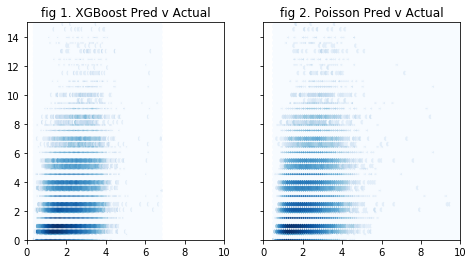

In [202]:
xmin = 0
xmax = 10
ymin = 0
ymax = 15


fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(7, 4))
fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
ax = axs[0]
hb = ax.hexbin(gsxgb_pred,y_test,bins='log', cmap='Blues')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("fig 1. XGBoost Pred v Actual")


ax = axs[1]
hb = ax.hexbin(p_pred,y_test, bins='log', cmap='Blues')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("fig 2. Poisson Pred v Actual")

plt.savefig('poisvsboost.png')
plt.show()

In [ ]:
PX_train, PX_test, Py_train, Py_test = train_test_split(newplayerbg, base_data['dk_points'], test_size=0.2, random_state=123)



In [ ]:
PX_train.head()

In [ ]:
Py_train.head()

In [ ]:
poisson_training_results = sm.GLM(Py_train, PX_train, family=sm.families.Poisson()).fit()


In [ ]:
print(poisson_training_results.summary())

In [ ]:
poisson_predictions = poisson_training_results.get_prediction(PX_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

In [ ]:
poisson_predictions = poisson_training_results.predict(PX_test)

In [ ]:
poisson_predictions

In [ ]:
poisson_predictions.mean()

In [ ]:
poisson_predictions.std()

In [ ]:
global_poisson = poisson_training_results.predict(newplayerbg)

In [ ]:
global_poisson = pd.DataFrame(global_poisson)
global_poisson.columns = ['poisson_pred']
global_poisson

In [ ]:
poisson_export = export.reset_index().merge(global_poisson, how="left",left_on=['player','game_id', 'game_order'], right_on=['player','game_id', 'game_order']).set_index('index')

In [ ]:
cols = ['game_date', "lastname","firstname",'poisson_pred']

poisson_export = poisson_export[cols]
poisson_export.set_index("game_date", inplace=True)

In [ ]:
finalpoisson_export = poisson_export[poisson_export.index.isin(dates)]

In [ ]:
finalpoisson_export.to_csv('first_poi_export.csv')

While there was significant improvement across the board it was enough to make 1/5 line-ups cash instead of 0/5, not nearly enough in a game where you need ~3/5 to cash to break even. Spliting the defensemen and the forwards was again attempted.

In [ ]:
dmen_targetp =  dmen['dk_points_x']
dmen_featuresp = dmen[vif_list['features'].tolist()]
forwards_targetp =  forwards['dk_points_x']
forwards_featuresp = forwards[vif_list['features'].tolist()]
## split the data
XD_train, XD_test, yD_train, yD_test = train_test_split(dmen_featuresp, dmen_targetp, test_size=0.2, random_state=123)

print( XD_train.shape, yD_train.shape)
print (XD_test.shape, yD_test.shape)
## split the data
XF_train, XF_test, yF_train, yF_test = train_test_split(forwards_featuresp, forwards_targetp, test_size=0.2, random_state=123)

print( XF_train.shape, yF_train.shape)
print (XF_test.shape, yF_test.shape)

In [ ]:
poisson_training_results_dmen = sm.GLM(yD_train, XD_train, family=sm.families.Poisson()).fit()
print(poisson_training_results_dmen.summary())


In [ ]:
poisson_predictions = poisson_training_results_dmen.get_prediction(XD_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

In [ ]:
dmen_ppred = poisson_training_results_dmen.predict(XD_test)
dmen_ppred = pd.DataFrame(dmen_ppred)
dmen_ppred.columns = ['poisson_pred']
dmen_ppred

In [ ]:
print(dmen_ppred.shape)
print(XD_test.shape)

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Pred vs Measured in Dmen - Poisson Regression and Trimmed Feature Tree', fontsize=18, fontweight='bold',pad=30)
ax.scatter( dmen_ppred["poisson_pred"],yD_test)
ax.plot([XD_test.min(), XD_test.max()], [XD_test.min(), XD_test.max()], 'k--', lw=4)
ax.set_ylabel('Measured')
ax.set_xlabel('Predicted')
plt.show()



In [ ]:
print(dmen_ppred['poisson_pred'].mean())
print(dmen_ppred['poisson_pred'].std())

In [ ]:
print(yD_pred.mean(),yD_test.mean())
print(yD_pred.std(),yD_test.std())

In [ ]:
poisson_training_results_forwards = sm.GLM(yF_train, XF_train, family=sm.families.Poisson()).fit()
print(poisson_training_results_forwards.summary())



In [ ]:
forwards_ppred = poisson_training_results_forwards.predict(XF_test)
forwards_ppred = pd.DataFrame(forwards_ppred)
forwards_ppred.columns = ['poisson_pred']
forwards_ppred

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Pred vs Measured in Forwards - Poisson Regression and Trimmed Feature Tree', fontsize=18, fontweight='bold',pad=30)
ax.scatter( forwards_ppred["poisson_pred"],yF_test)
ax.plot([XF_test.min(), XF_test.max()], [XF_test.min(), XF_test.max()], 'k--', lw=4)
ax.set_ylabel('Measured')
ax.set_xlabel('Predicted')
plt.show()



In [ ]:
print(forwards_ppred['poisson_pred'].mean())
print(forwards_ppred['poisson_pred'].std())
print(yF_pred.mean(),yF_test.mean())
print(yF_pred.std(),yF_test.std())

In [ ]:
poisson_predictions = poisson_training_results.predict(PX_test)

In [ ]:
print('mean D-Men: ',dmen_ppred['poisson_pred'].mean())
print('global mean: ',poisson_predictions.mean())
print('mean Forwards: ',forwards_ppred['poisson_pred'].mean())

In [ ]:
print('st. dv. D-Men: ',dmen_ppred['poisson_pred'].std())
print('global st. dv.: ',poisson_predictions.std())
print('st. dv. Forwards: ',forwards_ppred['poisson_pred'].std())

In [ ]:
print(poisson_predictions.mean())
print(poisson_predictions.std())

Noteable here is that in both cases the standard deviation tightened up from the last split model as well as the standard distribution. Just for fun these were joined back together and exported as well for testing.

In [ ]:
forwards_p = poisson_training_results_forwards.predict(forwards_featuresp)
dmen_p = poisson_training_results_forwards.predict(dmen_featuresp)

In [ ]:
forwards_p.head()

In [ ]:
dmen_p.head()

In [ ]:
joined_tables = forwards_p.append(dmen_p)

In [ ]:
segmented_poisson = pd.DataFrame(joined_tables)
segmented_poisson.columns = ['poisson_pred']
print(segmented_poisson.head)
segmented_poisson_export = export.reset_index().merge(segmented_poisson, how="left",left_on=['player','game_id', 'game_order'], right_on=['player','game_id', 'game_order']).set_index('index')
cols = ['game_date', "lastname","firstname",'poisson_pred']

segmented_poisson_export = segmented_poisson_export[cols]
segmented_poisson_export.set_index("game_date", inplace=True)
segmented_poisson_export.to_csv('second_poi_export.csv')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(playerbg,base_data['dk_points'], test_size=0.2, random_state=123)
poisson_training_results_restart = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [ ]:
print(poisson_training_results_restart.summary())

In [ ]:
poisson_restart_preds = poisson_training_results_restart.predict(X_test)

In [ ]:
poisson_restart_preds.mean()

In [ ]:
poisson_restart_preds.std()

In [ ]:
#yF_pred = gs_xgb.predict(XF_test)
print('R2:', r2_score(y_test, poisson_restart_preds)) 
print('Mean Absolute Error:', mean_absolute_error(y_test, poisson_restart_preds))  
print('Mean Squared Error:', mean_squared_error(y_test, poisson_restart_preds))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, poisson_restart_preds))) 

This showed noted progress and better error rates, but still almost a standard deviation off in the MAE. In order to further reduce noise a smaller subgroup of both the dmen and the forwards were selected, trimming off players that were more than a standard deviation below the mean in each both forwards and defensive players.

In [ ]:
import seaborn as sns
fig, ax = plt.subplots()
ax.set_title('Pred vs Measured in All Players - Poisson Regression All Features', fontsize=18, fontweight='bold',pad=30)
sns.kdeplot( poisson_restart_preds,y_test,cmap="Blues", shade=True)
#ax.plot([X_test.min(), X_test.max()], [X_test.min(), X_test.max()], 'k--', lw=2)
ax.set_ylabel('Measured')
ax.set_xlabel('Predicted')
plt.show()



In [ ]:
from scipy.stats import kde
from mpl_toolkits.mplot3d import Axes3D
nbins=300

k = kde.gaussian_kde([poisson_restart_preds,y_test])
xi, yi = np.mgrid[ poisson_restart_preds.min():poisson_restart_preds.max():nbins*1j, y_test.min():y_test.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Transform it in a dataframe
data=pd.DataFrame({'x': xi.flatten(), 'y': yi.flatten(), 'z': zi })
 
# Make the plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(data.x, data.y, data.z, cmap=plt.cm.Spectral, linewidth=0.2)
# Adapt angle, first number is up/down, second number is right/left
ax.view_init(30, 80)


In [ ]:
merged_preds = pd.DataFrame(zip(poisson_restart_preds,y_test))
merged_preds_sam = merged_preds.sample(5000)

In [ ]:
fig, ax = plt.subplots()
ax.hexbin( merged_preds_sam[0],merged_preds_sam[1], gridsize=(15,15), cmap="Greens")
#ax.plot([X_test.min(), X_test.max()], [X_test.min(), X_test.max()], 'k--', lw=2)
ax.set_ylabel('Measured')
ax.set_xlabel('Predicted')
plt.show()

In [ ]:
import seaborn as sns
fig, ax = plt.subplots()
ax.set_title('Pred vs Measured in All Players - Poisson Regression All Features', fontsize=18, fontweight='bold',pad=30)
sns.kdeplot( merged_preds_sam[0],merged_preds_sam[1],cmap="Blues", shade=True)
#ax.plot([X_test.min(), X_test.max()], [X_test.min(), X_test.max()], 'k--', lw=2)
ax.set_ylabel('Measured')
ax.set_xlabel('Predicted')
plt.show()

In [ ]:
##calculating averages
print('d-men average TOI: ', playerbg[playerbg.position_avg_D.isin(["1"])]["TOI_comp"].mean())
print('d-men std TOI: ', playerbg[playerbg.position_avg_D.isin(["1"])]["TOI_comp"].std())
print('forwards average TOI: ', playerbg[playerbg.position_avg_D.isin(["0"])]["TOI_comp"].mean())
print('forwards std TOI: ', playerbg[playerbg.position_avg_D.isin(["0"])]["TOI_comp"].std())

In [ ]:
new_cols = [col for col in playerbg.columns if '_avg' in col]

playerbg2 = playerbg[new_cols]
lost_cols = ['toi_signal', 'FF_signal','dk_points']

lost_cols = playerbg[lost_cols]
playerbg2 = playerbg2.merge(lost_cols, left_index=True, right_index=True)

playerbg_dmen = playerbg2[playerbg2.position_avg_D.isin(["1"])]
playerbg_forwards = playerbg2[playerbg2.position_avg_D.isin(["0"])]


In [ ]:
playerbg_forwards.shape

Players a standard deviation below their catagorical mean were cut to refine the process, meaning below 15.21 minutes for defensive players and below 10.71 for forwards.

In [ ]:
hv = playerbg_dmen['TOI_comp_avg_lf']>=15.21
                   
hv_playerbg_dmen = playerbg_dmen[hv]

In [ ]:
hv_playerbg_dmen.shape

In [ ]:
hvf = playerbg_forwards['TOI_comp_avg_lf']>=10.71
                   
hv_playerbg_fwds = playerbg_forwards[hvf]

In [ ]:
HFX_train, HFX_test, HFy_train, HFy_test = train_test_split(hv_playerbg_fwds[hv_playerbg_fwds.columns[0:230]], hv_playerbg_fwds['dk_points'], test_size=0.2, random_state=123)

poisson_hvf = sm.GLM(HFy_train, HFX_train, family=sm.families.Poisson()).fit()

In [ ]:
print(poisson_hvf.summary())

In [ ]:
poisson_hvf_preds = poisson_hvf.predict(HFX_test)

In [ ]:
#yF_pred = gs_xgb.predict(XF_test)
print('R2:', r2_score(HFy_test, poisson_hvf_preds)) 
print('Mean Absolute Error:', mean_absolute_error(HFy_test, poisson_hvf_preds))  
print('Mean Squared Error:', mean_squared_error(HFy_test, poisson_hvf_preds))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(HFy_test, poisson_hvf_preds))) 

In [ ]:
HDX_train, HDX_test, HDy_train, HDy_test = train_test_split(hv_playerbg_dmen[hv_playerbg_dmen.columns[0:230]], hv_playerbg_dmen['dk_points'], test_size=0.2, random_state=123)

poisson_hvd = sm.GLM(HDy_train, HDX_train, family=sm.families.Poisson()).fit()

In [ ]:
print(poisson_hvd.summary())

In [ ]:
poisson_hvd_preds = poisson_hvd.predict(HDX_test)

In [ ]:
print('R2:', r2_score(HDy_test, poisson_hvd_preds)) 
print('Mean Absolute Error:', mean_absolute_error(HDy_test, poisson_hvd_preds))  
print('Mean Squared Error:', mean_squared_error(HDy_test, poisson_hvd_preds))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(HDy_test, poisson_hvd_preds)))

In [ ]:
vif = pd.read_csv('vif3.csv')

hv_playerbg_fwds2 = hv_playerbg_fwds[vif['features'].tolist()]

HFX_train, HFX_test, HFy_train, HFy_test = train_test_split(hv_playerbg_fwds2, hv_playerbg_fwds['dk_points'], test_size=0.2, random_state=123)

poisson_hvfv = sm.GLM(HFy_train, HFX_train, family=sm.families.Poisson()).fit()

In [ ]:
print(poisson_hvfv.summary())

In [ ]:
poisson_hvfv_preds = poisson_hvfv.predict(HFX_test)

In [ ]:
print('R2:', r2_score(HFy_test, poisson_hvfv_preds)) 
print('Mean Absolute Error:', mean_absolute_error(HFy_test, poisson_hvfv_preds))  
print('Mean Squared Error:', mean_squared_error(HFy_test, poisson_hvfv_preds))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(HFy_test, poisson_hvfv_preds))) 

In [ ]:
HDX_train, HDX_test, HDy_train, HDy_test = train_test_split(hv_playerbg_dmen[vif['features'].tolist()], hv_playerbg_dmen['dk_points'], test_size=0.2, random_state=123)

poisson_hvdv = sm.GLM(HDy_train, HDX_train, family=sm.families.Poisson()).fit()

In [ ]:
print(poisson_hvdv.summary())

In [ ]:
poisson_hvdv_preds = poisson_hvdv.predict(HDX_test)

In [ ]:
print('R2:', r2_score(HDy_test, poisson_hvdv_preds)) 
print('Mean Absolute Error:', mean_absolute_error(HDy_test, poisson_hvdv_preds))  
print('Mean Squared Error:', mean_squared_error(HDy_test, poisson_hvdv_preds))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(HDy_test, poisson_hvdv_preds))) 

In [ ]:
merged_Dpreds = pd.DataFrame(zip(poisson_hvdv_preds,HDy_test))
merged_Dpreds_sam = merged_preds.sample(5000)

fig, ax = plt.subplots()
ax.set_title('Pred vs Measured in All Players - Poisson Regression All Features', fontsize=18, fontweight='bold',pad=30)
ax.hexbin(merged_Dpreds_sam[0],merged_Dpreds_sam[1],gridsize=(15,15), cmap='Greens')
#ax.plot([X_test.min(), X_test.max()], [X_test.min(), X_test.max()], 'k--', lw=2)
ax.set_ylabel('Measured')
ax.set_xlabel('Predicted')
plt.show()



Given that the global model is the most successful as far as variance explained and close on error metrics, as well as having the widest application, that will be our winner in this case.

In [ ]:
import pickle
pickle.dumps(poisson_training_results_restart) 

In [ ]:
from sklearn.externals import joblib
import pickle
import bz2
# Save to file in the current working directory
jsfile = bz2.BZ2File('capstone_2_final_poisson', 'w')
joblib.dump(poisson_training_results_restart, jsfile)